In [ ]:
df.columns

Index(['Fe_pct', 'Cr_pct', 'Ni_pct', 'Weld_V', 'Weld_S', 'Repair_Cycle',
       'Yield_MPa', 'UTS_MPa', 'Curve_Points (Flattened)'],
      dtype='object')

In [24]:
import pandas as pd
import numpy as np
import json

def generate_vssc_ai_dataset(n_samples=200):
    data = []
    for i in range(n_samples):
        # 1. Input Features (Chemicals & Process)
        fe = np.random.uniform(65, 75)
        cr = np.random.uniform(15, 20)
        ni = np.random.uniform(8, 12)
        v = np.random.uniform(10, 15)  # Weld Voltage
        repair = np.random.choice([0, 1, 2]) # R0, R1, R2

        # 2. Calculate Scalar Properties
        # Formula: UTS increases with Cr/Ni, decreases with Repair cycles
        uts = (cr * 22) + (ni * 6) + 100 - (repair * 40) + np.random.normal(0, 5)
        yield_p = uts * 0.45 + np.random.normal(0, 2)
        max_strain = 0.35 - (repair * 0.05) # Ductility drops with repairs

        # 3. Generate Full Curve (100 Coordinates per sample)
        strain_points = np.linspace(0, max_strain, 100)
        # Power Law (Hollomon): Stress = K * Strain^n
        n = 0.15
        k = uts / (max_strain**n)
        stress_points = k * (strain_points**n)
        stress_points[0] = 0 # Starting point

        data.append({
            'Fe_pct': round(fe, 2),
            'Cr_pct': round(cr, 2),
            'Ni_pct': round(ni, 2),
            'Weld_V': round(v, 2),
            'Repair_Cycle': repair,
            'Yield_MPa': round(yield_p, 2),
            'UTS_MPa': round(uts, 2),
            'Stress_Curve': json.dumps(stress_points.tolist()), # Full Curve Y-axis
            'Strain_Curve': json.dumps(strain_points.tolist())  # Full Curve X-axis
        })
    return pd.DataFrame(data)

# Generate and Save
df = generate_vssc_ai_dataset(200)
df.to_csv('VSSC_Full_AI_Data.csv', index=False)
print("File 'VSSC_Full_AI_Data.csv' created successfully with full curves.")

File 'VSSC_Full_AI_Data.csv' created successfully with full curves.


In [26]:
import pandas as pd
import numpy as np
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# --- 1. CONFIGURATION ---
INPUT_COLS = ['Fe_pct', 'Cr_pct', 'Ni_pct', 'Weld_V', 'Repair_Cycle']
SCALAR_TARGETS = ['Yield_MPa', 'UTS_MPa']
CURVE_LEN = 100  # Number of points in your Stress/Strain vectors

# --- 2. DATA PREPROCESSING ---
def load_and_preprocess(file_path):
    df = pd.read_csv(file_path)

    # Scale Inputs
    scaler_x = StandardScaler()
    X = scaler_x.fit_transform(df[INPUT_COLS])

    # Scalar Targets (Yield, UTS)
    y_scalars = df[SCALAR_TARGETS].values

    # Vector Targets (Parsing JSON strings to Numpy)
    y_stress = np.array([json.loads(c) for c in df['Stress_Curve']])
    y_strain = np.array([json.loads(c) for c in df['Strain_Curve']])

    # Convert to PyTorch Tensors
    X_t = torch.tensor(X, dtype=torch.float32)
    y_s_t = torch.tensor(y_scalars, dtype=torch.float32)
    y_stress_t = torch.tensor(y_stress, dtype=torch.float32)
    y_strain_t = torch.tensor(y_strain, dtype=torch.float32)

    return X_t, y_s_t, y_stress_t, y_strain_t, scaler_x

# --- 3. MODEL ARCHITECTURE ---
class VSSC_MaterialAI(nn.Module):
    def __init__(self, input_dim=5, vector_dim=100):
        super(VSSC_MaterialAI, self).__init__()

        # Shared Backbone (Feature Extraction)
        self.backbone = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128)
        )

        # Branch 1: Predict Yield and UTS
        self.scalar_head = nn.Linear(128, 2)

        # Branch 2: Predict the Stress Vector
        self.stress_head = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, vector_dim)
        )

        # Branch 3: Predict the Strain Vector
        self.strain_head = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, vector_dim)
        )

    def forward(self, x):
        features = self.backbone(x)
        scalars = self.scalar_head(features)
        stress_curve = self.stress_head(features)
        strain_curve = self.strain_head(features)
        return scalars, stress_curve, strain_curve

# --- 4. TRAINING LOGIC ---
def train_vssc_model(csv_path):
    # Prepare Data
    X, y_s, y_stress, y_strain, scaler = load_and_preprocess(csv_path)
    dataset = TensorDataset(X, y_s, y_stress, y_strain)
    loader = DataLoader(dataset, batch_size=16, shuffle=True)

    model = VSSC_MaterialAI(input_dim=len(INPUT_COLS))
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    print(f"Training on {len(X)} samples...")

    for epoch in range(151):
        model.train()
        total_loss = 0

        for b_x, b_s, b_stress, b_strain in loader:
            optimizer.zero_grad()

            p_s, p_stress, p_strain = model(b_x)

            # Multi-Task Loss calculation
            loss_s = criterion(p_s, b_s)
            loss_stress = criterion(p_stress, b_stress)
            loss_strain = criterion(p_strain, b_strain)

            # Summing losses (Weighting scalars more for initial stability)
            combined_loss = loss_s + 0.5 * loss_stress + 0.5 * loss_strain

            combined_loss.backward()
            optimizer.step()
            total_loss += combined_loss.item()

        if epoch % 50 == 0:
            print(f"Epoch {epoch:3} | Loss: {total_loss/len(loader):.6f}")

    return model, scaler

# --- 5. EXECUTION & SAVE ---
# Replace with your actual filename
filename = '/content/VSSC_Full_AI_Data (1).csv'
trained_model, data_scaler = train_vssc_model(filename)

# Save the model for future use
torch.save(trained_model.state_dict(), 'vssc_material_model.pth')
print("Model saved as vssc_material_model.pth")

Training on 200 samples...
Epoch   0 | Loss: 249087.102163
Epoch  50 | Loss: 92530.512019
Epoch 100 | Loss: 16177.710261
Epoch 150 | Loss: 663.608889
Model saved as vssc_material_model.pth


In [27]:
import joblib
joblib.dump(scaler, 'scaler.joblib')

['scaler.joblib']

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


--- AI PREDICTION RESULTS ---
Predicted Yield Strength: 203.50 MPa
Predicted UTS: 398.39 MPa


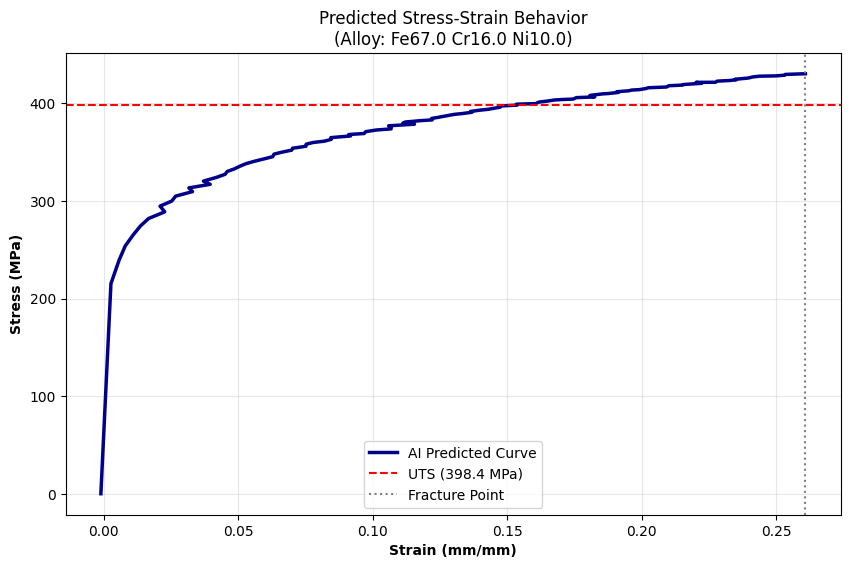

In [18]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import json
from sklearn.preprocessing import StandardScaler

# --- 1. SETUP PREDICTION ENVIRONMENT ---
# Define the same architecture as used in training
class VSSC_MaterialAI(torch.nn.Module):
    def __init__(self, input_dim=5, vector_dim=100):
        super(VSSC_MaterialAI, self).__init__()
        self.backbone = torch.nn.Sequential(
            torch.nn.Linear(input_dim, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 128),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(128)
        )
        self.scalar_head = torch.nn.Linear(128, 2)
        self.stress_head = torch.nn.Sequential(
            torch.nn.Linear(128, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, vector_dim)
        )
        self.strain_head = torch.nn.Sequential(
            torch.nn.Linear(128, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, vector_dim)
        )

    def forward(self, x):
        features = self.backbone(x)
        scalars = self.scalar_head(features)
        stress_curve = self.stress_head(features)
        strain_curve = self.strain_head(features)
        return scalars, stress_curve, strain_curve

# --- 2. LOAD MODEL AND SCALER ---
def load_predictor(model_path, input_dim=5):
    model = VSSC_MaterialAI(input_dim=input_dim)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

# --- 3. PREDICTION FUNCTION ---
def get_prediction(model, scaler, fe, cr, ni, v, repair):
    # Prepare input
    raw_input = np.array([[fe, cr, ni, v, repair]])
    scaled_input = torch.tensor(scaler.transform(raw_input), dtype=torch.float32)

    with torch.no_grad():
        scalars, stress_vec, strain_vec = model(scaled_input)

    return {
        'Yield': scalars[0][0].item(),
        'UTS': scalars[0][1].item(),
        'Stress': stress_vec.squeeze().numpy(),
        'Strain': strain_vec.squeeze().numpy()
    }

# --- 4. RUN PREDICTION & PLOT ---
# Load your trained model
# Note: Ensure 'data_scaler' from your training script is available in your workspace
predictor = load_predictor('vssc_material_model.pth')

# INPUT PARAMETERS FOR PREDICTION
# Example: Fe=70%, Cr=18%, Ni=10%, V=12.5, Repair=1
test_params = {
    'fe': 67.0,
    'cr': 16.0,
    'ni': 10.0,
    'v': 12.5,
    'repair': 2
}

res = get_prediction(predictor, data_scaler, **test_params)

print(f"--- AI PREDICTION RESULTS ---")
print(f"Predicted Yield Strength: {res['Yield']:.2f} MPa")
print(f"Predicted UTS: {res['UTS']:.2f} MPa")

# Visualizing the behavioral vector
plt.figure(figsize=(10, 6))
plt.plot(res['Strain'], res['Stress'], color='darkblue', linewidth=2.5, label='AI Predicted Curve')
plt.axhline(y=res['UTS'], color='r', linestyle='--', label=f"UTS ({res['UTS']:.1f} MPa)")
plt.axvline(x=res['Strain'][-1], color='gray', linestyle=':', label='Fracture Point')

plt.title(f"Predicted Stress-Strain Behavior\n(Alloy: Fe{test_params['fe']} Cr{test_params['cr']} Ni{test_params['ni']})", fontsize=12)
plt.xlabel("Strain (mm/mm)", fontweight='bold')
plt.ylabel("Stress (MPa)", fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

[0.0, 0.002525252525252525, 0.00505050505050505, 0.007575757575757575, 0.0101010101010101, 0.012626262626262624, 0.01515151515151515, 0.017676767676767676, 0.0202020202020202, 0.022727272727272724, 0.02525252525252525, 0.027777777777777776, 0.0303030303030303, 0.032828282828282825, 0.03535353535353535, 0.03787878787878787, 0.0404040404040404, 0.04292929292929293, 0.04545454545454545, 0.047979797979797977, 0.0505050505050505, 0.053030303030303025, 0.05555555555555555, 0.05808080808080807, 0.0606060606060606, 0.06313131313131312, 0.06565656565656565, 0.06818181818181818, 0.0707070707070707, 0.07323232323232323, 0.07575757575757575, 0.07828282828282827, 0.0808080808080808, 0.08333333333333333, 0.08585858585858586, 0.08838383838383837, 0.0909090909090909, 0.09343434343434343, 0.09595959595959595, 0.09848484848484848, 0.101010101010101, 0.10353535353535352, 0.10606060606060605, 0.10858585858585858, 0.1111111111111111, 0.11363636363636363, 0.11616161616161615, 0.11868686868686867, 0.12121212

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


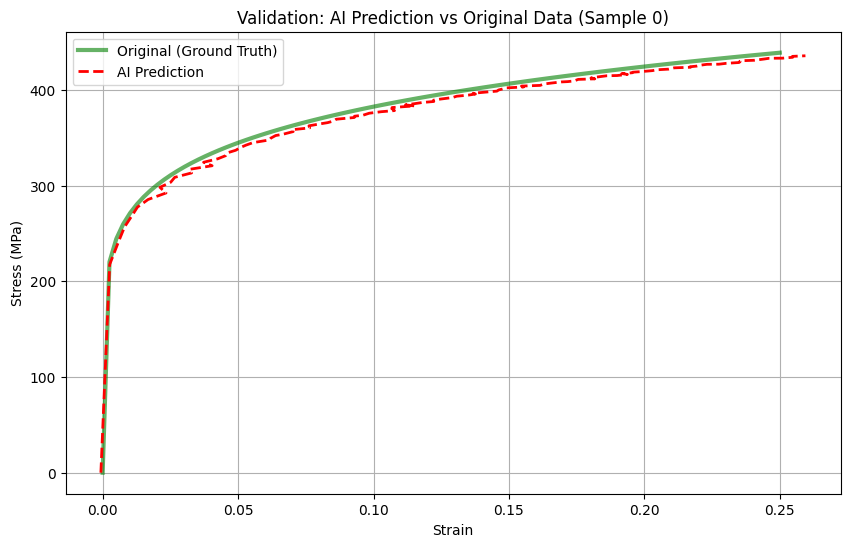

In [23]:
def compare_ai_with_original(index, model, scaler):
    # Get Original Data
    sample = df.iloc[index]
    orig_stress = json.loads(sample['Stress_Curve'])
    orig_strain = json.loads(sample['Strain_Curve'])

    print(orig_strain)
    # Get AI Prediction for the same inputs
    model.eval()
    raw_input = np.array([[sample['Fe_pct'], sample['Cr_pct'], sample['Ni_pct'], sample['Weld_V'], sample['Repair_Cycle']]])
    scaled_input = torch.tensor(scaler.transform(raw_input), dtype=torch.float32)

    with torch.no_grad():
        _, pred_stress_vec, pred_strain_vec = model(scaled_input)

    p_stress = pred_stress_vec.squeeze().numpy()
    p_strain = pred_strain_vec.squeeze().numpy()
    # print(p_strain)

    # Plot Comparison
    plt.figure(figsize=(10, 6))
    plt.plot(orig_strain, orig_stress, 'g-', alpha=0.6, linewidth=3, label='Original (Ground Truth)')
    plt.plot(p_strain, p_stress, 'r--', linewidth=2, label='AI Prediction')

    plt.title(f"Validation: AI Prediction vs Original Data (Sample {index})")
    plt.xlabel("Strain")
    plt.ylabel("Stress (MPa)")
    plt.legend()
    plt.grid(True)
    plt.show()

# Usage:
compare_ai_with_original(0, trained_model, data_scaler)
